# Stations
This notebook is mainly used to plot a map with the sations on it

In [95]:
from utils.data import load_dataframes

In [96]:
df = load_dataframes(mode="train", leadtime="24h")
stations = df["stations"]

[INFO] Dataframes exist. Will load pandas dataframes.


In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams.update({'text.usetex': True,
                     'font.family': 'Computer Modern Roman',
                     'text.latex.preamble': r'\usepackage{amsmath} \usepackage{siunitx}',
                     'font.size': 16})
%matplotlib inline

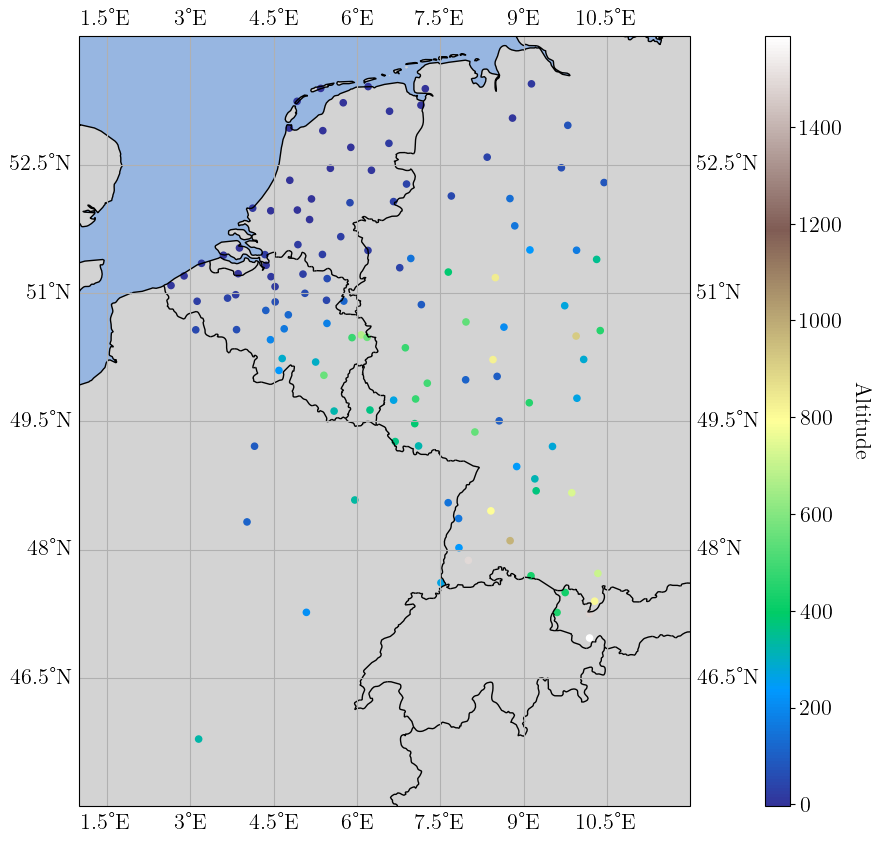

In [5]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_extent([1, 12, 45, 54], crs=proj)
ax.add_feature(cfeature.LAND, color="lightgrey")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)

plot = ax.scatter(stations['lon'], stations['lat'], c=stations['altitude'], cmap='terrain', s=20, transform=proj)

norm = plt.Normalize(vmin=min(stations.altitude), vmax=max(stations.altitude))
sm_nodes = plt.cm.ScalarMappable(cmap="terrain", norm=norm)
colbar = plt.colorbar(sm_nodes, ax=ax, aspect=30, pad=0.08)
colbar.ax.set_ylabel(r'$\mathrm{Altitude}$', rotation=270, labelpad=20)

ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
ax.set_rasterized(True)

## Fix the aspect ratio of the map
lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
ax.set_aspect(1 / np.cos(np.radians(lat_center)))

plt.savefig("figures/stations.pdf", format="pdf", bbox_inches="tight", dpi=300)

## Plot Graph
Plot of the stations with their connections

In [97]:
from utils.data import (load_distances, normalize_features_and_create_graphs)
import networkx as nx
import numpy as np
import torch

In [98]:
dist = load_distances(df["stations"])
graphs_train_rf, tests = normalize_features_and_create_graphs(
        training_data=df["train"],
        valid_test_data=[df["test_rf"], df["test_f"]],
        mat=dist,
        max_dist=100,
    )

[INFO] Loading distances from file...
[INFO] Normalizing features...
[INFO] Creating graph data...


In [101]:
d = graphs_train_rf[0]
d.pos = torch.Tensor([stations[["lat","lon"]].iloc[i] for i in d.n_idx.tolist()])

/var/folders/8h/0y2pf_1n2735m_vsyhnb7lkw0000gn/T/ipykernel_26182/3770612526.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d.pos = torch.Tensor([stations[["lat","lon"]].iloc[i] for i in d.n_idx.tolist()])


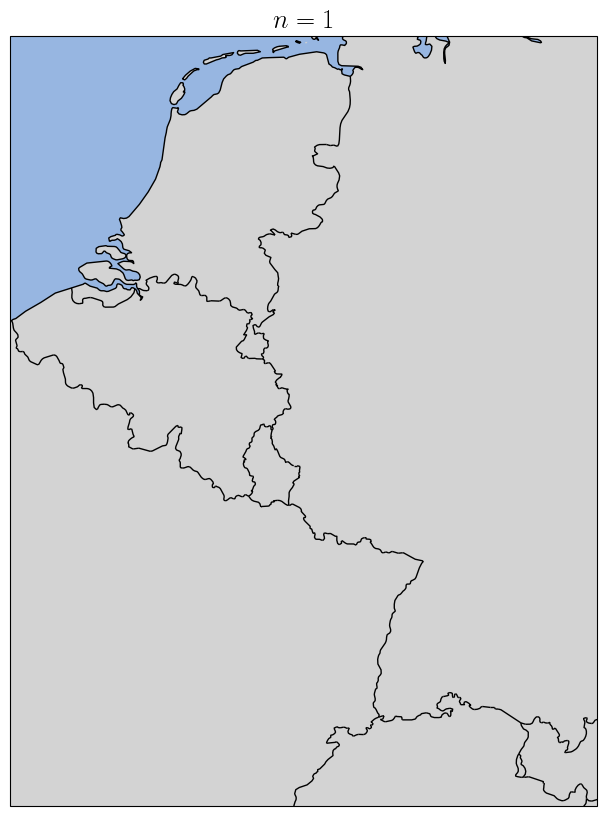

In [117]:

lightblue = (209/255,220/255,252/255,1)
blue = (40/255, 86/255, 246/255,1)

lightred = (248/255,210/255,226/255,1)
red = (234/255,59/255,118/255,1)


if d.is_directed():
    G = nx.DiGraph()
else:
    G = nx.Graph()

# to cpu for further calculations and plotting
edge_index, dist = d.edge_index.cpu().numpy(), d.edge_attr.cpu().numpy()

# NOTE: edge_index_att holds the Edges of the new graph,
# however they are labeled consecutively instead of the ordering from stations DataFrame
station_ids = np.array(d.x[:, 0])
edge_index = station_ids[edge_index]  # now the same indexes as in the stations Dataframe are used

# Add nodes (stations) to the graph
for i in range(d.num_nodes):
    G.add_node(int(d.x[i,0]), lon=float(d.pos[i,0]), lat=float(d.pos[i,1]))  # Add station with ID, LAT and LON

pos = {node: (data['lat'], data['lon']) for node, data in
        G.nodes(data=True)}  # Create a positions dict

# Add edges with edge_length as an attribute
if d.is_directed():
    for edge, a in zip(edge_index.T.tolist(), dist.flatten().tolist()):  # Add all edges
        G.add_edge(edge[0], edge[1], length=a)  # Add all Edges with distance Attribute
else:
    for edge, a in zip(edge_index.T.tolist(), dist.flatten().tolist()):
        if not (G.has_edge(edge[0], edge[1]) or G.has_edge(edge[1], edge[0])):  # Edge only needs to be added once
            G.add_edge(edge[0], edge[1], length=a)  # Add all Edges with distance Attribute
            
# Remove self loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

# Colors
degrees = G.degree if d.is_undirected() else G.in_degree

node_colors = [deg for _, deg in degrees]
cmap_nodes = plt.get_cmap('jet', max(node_colors) - min(node_colors) + 1)
norm = plt.Normalize(min(node_colors), max(node_colors))
colors_n = [cmap_nodes(norm(value)) for value in node_colors]
sm_nodes = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=norm)

# Edge Colors
color_values = [attr['length'] for _, _, attr in G.edges(data=True)]
cmap = mpl.colormaps.get_cmap('bone')
# Normalize the values to range between 0 and 1
norm = plt.Normalize(min(color_values), max(color_values))
# Generate a list of colors based on the normalized values
colors = [cmap(norm(value)) for value in color_values]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

#Map
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_extent([1, 12, 45, 54], crs=proj)
ax.add_feature(cfeature.LAND, color="lightgrey")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)

# # Colorbar Node degrees
# if not all(node_colors[0] == col for col in node_colors[1:]):  # only add colorbar if there are different degrees
#     colorbar = plt.colorbar(sm_nodes, ax=ax)
#     ticks_pos = np.linspace(min(node_colors) + 1, max(node_colors), max(node_colors) - min(node_colors) + 1) - 0.5
#     colorbar.set_ticks(ticks_pos)
#     ticks = np.arange(min(node_colors), max(node_colors) + 1)
#     colorbar.set_ticklabels(ticks)
#     colorbar.ax.set_ylabel(f'Node{"_in" if d.is_directed() else ""} Degree', rotation=270, labelpad=20)

# # Colormap for Edges
# colorbar_e = plt.colorbar(sm, ax=ax)
# colorbar_e.ax.set_ylabel('Distance in km', rotation=270, labelpad=20)

# Plot Graph
nx.draw_networkx(G,
                    pos=pos,
                    node_size=60,
                    node_color=[lightblue], #colors_n
                    ax=ax,
                    with_labels=False,
                    edge_color=colors,
                    edgecolors=blue)

# ! Just for scaling reasons
ax.set_ylim(46.8, 53.6)
ax.set_xlim(2.5, 10.6)

# Fix the aspect ratio of the map
lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
ax.set_aspect(1 / np.cos(np.radians(lat_center)))

ax.set_title("$n=1$")
ax.set_rasterization_zorder(2)
plt.savefig("figures/input_map_.pdf", format="pdf", bbox_inches="tight")